# Reinforcement Learning Basics

In this demo, we will play around with the environments available through [Gym](https://www.gymlibrary.dev/).

## Libraries

For visualizing our agent playing, we'll need to load the following library.

In [ ]:
!pip3 install imageio==2.4.1
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=d72468a797d6c17a7567acf160a113929298876045eb5d031bb19cbbe8867180
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 15.8 MB/s eta 0:00:00


In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
import matplotlib.pyplot as plt
import numpy as np
import gym

import moviepy.video.io.ImageSequenceClip
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2457600/45929032 bytes (5.4%)4366336/45929032 bytes (9.5%)6586368/45929032 bytes (14.3%)8994816/45929032 bytes (19.6%)11567104/45929032 bytes (25.2%)14090240/45929032 bytes (30.7%)16252928/45929032 bytes (35.4%)18104320/45929032 bytes (39.4%)20004864/45929032 bytes (43.6%)22142976/45929032 bytes (48.2%)24313856/45929032 bytes (52.9%)25796608/45929032 bytes (56.2%)282

Check out a list of classic games [here](https://www.gymlibrary.dev/environments/classic_control/). We'll be experimenting with Cart Pole where the object is to keep a pole on top of a cart without falling.

In [ ]:
env = gym.make('CartPole-v1')

  deprecation(

  deprecation(



The observation space consits of four variables:

* Cart position (on a line)

* Cart velocity

* Pole angle

* Pole angular velocity


In [ ]:
print(env.observation_space)
print(env.observation_space.shape)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
(4,)


We can take two actions: either push the cart to the left or to the right.

In [ ]:
print(env.action_space)

Discrete(2)


The game is actually pretty hard! You can try your hand at it [here](https://jeffjar.me/cartpole.html). Now let's train a policy to beat it. We start by loading two different copies of the environment; one for training and one for testing.

In [ ]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

We'll train a neural network that is actually incredibly simple: only two layers with dropout and ReLU.

In [ ]:
class PolicyNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout=.5):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):
    return self.net(x)

As we've done many times before, we initialize our architecture and optimizer. However, the loss will be slightly more tricky to compute than normal.

In [ ]:
input_dim = train_env.observation_space.shape[0]
print('input dim:', input_dim)

output_dim = train_env.action_space.n
print('output dim:', output_dim)

hidden_dim = 128

policy = PolicyNet(input_dim, hidden_dim, output_dim)
print(policy)

optimizer = optim.Adam(policy.parameters(), lr=0.01)

input dim: 4
output dim: 2
PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


We will write a function for calculating a sequence of returns. With these in hand, we can calculate the empirical average over many trajectories as described in the lecture [notes](https://chinmayhegde.github.io/dl-notes/notes/lecture09/).

In [ ]:
def calculate_returns(rewards, discount_factor, normalize=True):
  returns = []
  R = 0
  for r in reversed(rewards):
    R = r + R * discount_factor
    returns.insert(0,R)

  returns = torch.tensor(returns)
  # Remember we normalize to differentiate between
  # "good" and "bad" actions
  if normalize:
    returns = (returns - returns.mean()) / returns.std()
  
  return returns

Once we have returns and log probabilities of the actions we take, we will compute the loss and optimize.

In [ ]:
def update_policy(returns, log_prob_actions, optimizer):
  returns = returns.detach()
  # Because we minimize (by convention) and we actually
  # want to maximize returns, we negate the expected sum
  loss = - (returns * log_prob_actions).sum()
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  return loss.item()

Now we write the training and evaluation functions. Notice how training in RL is more involved than our standard applications.

In [ ]:
def train(env, policy, optimizer, discount_factor=.99):
  policy.train() #turns on dropout
  
  log_prob_actions = []
  rewards = []
  done = False
  episode_reward = 0

  state = env.reset()

  while not done:
    # will get probability of each action recommebded by the policy
    state = torch.FloatTensor(state).unsqueeze(0)
    action_pred = policy(state)
    action_prob = F.softmax(action_pred, dim = -1) #prob go left, right
    # sample an action from this distribution
    dist = distributions.Categorical(action_prob)
    action = dist.sample() # we sample (rather than take the best)
    # compute log_prob_action and add it to our list
    log_prob_action = dist.log_prob(action)
    log_prob_actions.append(log_prob_action)
    # take action and go to new state
    state, reward, done, _ = env.step(action.item())
    # update our reward
    rewards.append(reward)

    episode_reward += reward
  
  log_prob_actions = torch.cat(log_prob_actions) #one torch tensor
  #calculate return: need returns, discount
  returns = calculate_returns(rewards, discount_factor)
  #update policy
  loss = update_policy(returns, log_prob_actions, optimizer)

  return loss, episode_reward


In [ ]:
def evaluate(env, policy, return_frames=False):
  policy.eval() #turns off the dropout


  done = False
  episode_reward = 0
  state = env.reset()
  frames = []

  while not done:
    if return_frames:
      frames += [env.render(mode='rgb_array')]
    state = torch.FloatTensor(state).unsqueeze(0)

    action_pred = policy(state)
    action_prob = F.softmax(action_pred, dim=-1)

    action = torch.argmax(action_prob, dim=-1) # we take the best action (instead of sampling)
    state, reward, done, _ = env.step(action.item())
    episode_reward += reward
  
  if return_frames:
    return episode_reward, frames
  return episode_reward

Now we're ready to train. Notice the very jagged nature of the loss history. This is because RL is different from our regular training: our policy is stochastic and the reward is more "sparse".

In [ ]:
max_episodes = 500
num_trials = 25
reward_threshold = 475
print_every = 10

train_rewards = []
test_rewards = []

for episode in range(1, max_episodes+1):
  loss, train_reward = train(train_env, policy, optimizer)
  test_reward = evaluate(test_env, policy)

  train_rewards += [train_reward]
  test_rewards += [test_reward]

  mean_train_rewards = np.mean(train_rewards[-num_trials:])
  mean_test_rewards = np.mean(test_rewards[-num_trials:])

  if episode % print_every == 0:    
    print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
  if mean_test_rewards >= reward_threshold:
    print(f'Reached reward threshold in {episode} episodes')
    break


Reached reward threshold in 1 episodes


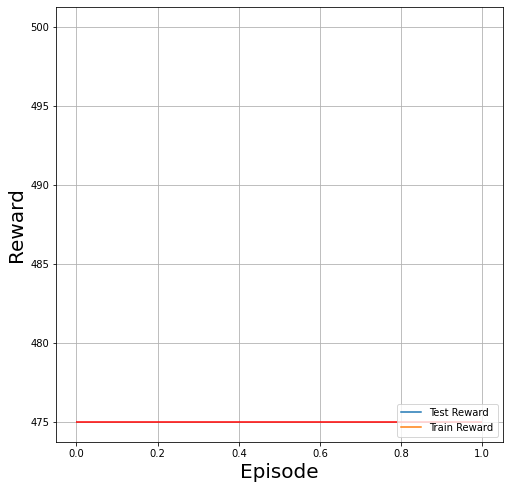

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(reward_threshold, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [ ]:
_, frames = evaluate(test_env, policy, return_frames = True)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



In [ ]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=50)
ipython_display(clip)

100%|██████████| 500/500 [00:02<00:00, 200.96it/s]
